Notes 

This challegen consists of multi-class classification problem (5 targets) and it concerns images of beer (glass bottles). The goal is to assign the correct beer brand to each image (Chimay Blue, Orval, Rochefort 10, Westmalle Tripel and Westvleteren 12, 0-4, respectively).

The inital idea is to train the model on the training data and test the performance on the eval data (that's our testing set). Once that's done, and we're happy with out model, we should train it on ALL available data of course, and only then deploy it to GCP.

Ideas 

The task that lies before us is a fairly straightforward multiclass classification with images. The obvious solution here is to use a CNN. We can either build our own, or perhaps use a pre-trained model. I think transfer learning theory may be quite useful here. Additionally, image augmentation could be useful to improve the generalisation of the model. Data are already normalised to begin with 

Update #1 \
My constructed CNN seems to work quite well, adam optimiser appears to be the way to go, and batch siez of 10 is ideal. 
I also checked and what made this challenge easier is not having any obvious class imbalances, there are about 100 photos of beer per category (class-weighting, over/under-sampling, or some preferential data augmentation not necessary).

Update #2 \
Leveraged transfer learning theory with VGG16 - works perfectly, better than my model. Set all weights within to untrainable. I also created a figure with the loss - very good convergence without apparent overfitting. 

Update #3 \
I implemented data augmentation, I added this to the task.py and task-final.py. I could add it to model.py, but this works fine

Final update \
VGG16 pre-trained network with data augmentation and 120 epochs (trained in PyCharm on a different laptop with Nvidia, 4 times faster). The final loss was quite smooth though, which I'm very pleased with. 

In [1]:
#For checking the JSON file works corretly 
import json

In [37]:
with open('check_deployed_model/test.json') as f:
    d = json.load(f)
    print(d["instances"][0].keys())

dict_keys(['bytes'])


In [ ]:
!gcloud ai endpoints predict ID \
    --project=PROJECT_ID  \
    --region=europe-west1 \
    --json-request=check_deployed_model/test.json

In [3]:
model_path = "output/exported_model"
loaded_model = tf.saved_model.load(model_path)

In [7]:
loaded_model.signatures

_SignatureMap({'serving_default': <ConcreteFunction (*, inputs: TensorSpec(shape=(None,), dtype=tf.string, name='inputs')) -> Dict[['output_1', TensorSpec(shape=(None, 5), dtype=tf.float32, name='output_1')], ['output_0', TensorSpec(shape=(None,), dtype=tf.int64, name='output_0')]] at 0x164504D10>})

In [125]:
!python3 -m trainer.task

Epoch 1/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.4026 - loss: 2.9809
Epoch 2/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.8486 - loss: 0.5482
Epoch 3/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.9492 - loss: 0.1297
Epoch 4/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9807 - loss: 0.0441
Epoch 5/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 1.0000 - loss: 0.0111
Epoch 6/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 1.0000 - loss: 0.0040
Epoch 7/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 1.0000 - loss: 0.0020
Epoch 8/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 1.0000 - loss: 0.0011
Epoch 9/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 1.0000 - loss: 0.0015
Epoch 10/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 1.0000 - loss: 7.3926e-04
Epoch 11/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 1.0000 - loss: 0.0011
Epoch 12/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 1.0

In [11]:
%%writefile trainer/model.py
#!/usr/bin/env python3

"""Model to classify draft beers

This file contains all the model information: the training steps, the batch
size and the model itself.
"""

import tensorflow as tf

def get_batch_size():
    """Returns the batch size that will be used by your solution.
    It is recommended to change this value.
    """
    return 10

def get_epochs():
    """Returns number of epochs that will be used by your solution.
    It is recommended to change this value.
    """
    return 120

def solution(input_layer):
    """Returns a compiled model.

    This function is expected to return a model to identity the different beers.
    The model's outputs are expected to be probabilities for the classes and
    and it should be ready for training.
    The input layer specifies the shape of the images. The preprocessing
    applied to the images is specified in data.py.

    Add your solution below.

    Parameters:
        input_layer: A tf.keras.layers.InputLayer() specifying the shape of the input.
            RGB colored images, shape: (width, height, 3)
    Returns:
        model: A compiled model
    """


    # Using the VGG16, pre-trained network based on ImageNet (developed at Oxford, seems appropraite)

    # The easiest thing to do here is to hardcode the image size. Terrible, but ideal for the purposes of this challenge
    img_size = [160, 160]

    # Make sure to exclude the top layer, we can do this ourselves 
    ptm = tf.keras.applications.vgg16.VGG16(
        input_shape=img_size + [3],
        weights='imagenet',
        include_top=False)

    # Avoid retraining the weights, the top will so
    ptm.trainable = False

    # Construct the top layers 
    i = ptm.input # I'm being a bit cheeky here and using the ptm input layer, not the one provided by the code 
    x = tf.keras.layers.Flatten()(ptm.output)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    # Hardcode the number of beers
    x = tf.keras.layers.Dense(5, activation='softmax')(x)

    # There are 63 steps per epoch, 120 epochs, 7560 steps, which means a decrease of 28 % 
    initial_learning_rate = 0.001
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=initial_learning_rate,
            decay_steps=1000,  
            decay_rate=0.96,   # 4% decrease every 1000 steps
            staircase=True)

    # Finalise and compile the model with the learning rate scheduler, include accuracy 
    model = tf.keras.models.Model(i, x)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Return the compiled model
    return model

Overwriting trainer/model.py


In [25]:
%%writefile trainer/task.py
#!/usr/bin/env python3

"""Train and evaluate the model

This file trains the model upon the training data and evaluates it with
the eval data.
It uses the arguments it got via the gcloud command.
"""

import os
import argparse
import logging

import tensorflow as tf

import trainer.data as data
import trainer.model as model

import matplotlib.pyplot as plt


def train_model(params):
    """The function gets the training data from the training folder,
    the evaluation data from the eval folder and trains your solution
    from the model.py file with it.

    Parameters:
        params: parameters for training the model
    """
    (train_data, train_labels) = data.create_data_with_labels("data/train/")
    (eval_data, eval_labels) = data.create_data_with_labels("data/eval/")

    img_shape = train_data.shape[1:]
    input_layer = tf.keras.Input(shape=img_shape, name='input_image')

    ml_model = model.solution(input_layer)

    if ml_model is None:
        print("No model found. You need to implement one in model.py")
    else:
        r = ml_model.fit(train_data, train_labels,
                     batch_size=model.get_batch_size(),
                     epochs=model.get_epochs())
        
        fig, ax = plt.subplots(figsize = (10,10))
        plt.plot(r.history['loss'], label='train loss')
        plt.plot(r.history['accuracy'], label='accuracy')
        plt.legend()
        fig.savefig("V2_ML6.svg")
        
        ml_model.evaluate(eval_data, eval_labels, verbose=1)

if __name__ == "__main__":
    parser = argparse.ArgumentParser()

    args = parser.parse_args()
    tf_logger = logging.getLogger("tensorflow")
    tf_logger.setLevel(logging.INFO)
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = str(tf_logger.level // 10)

    train_model(args)


Overwriting trainer/task.py


In [10]:
%%writefile trainer/final_task.py
# %load trainer/final_task.py
#!/usr/bin/env python3

"""Train and export the model

This file trains the model upon all data with the arguments it got via
the gcloud command.
"""

import os
import argparse
import logging

from pathlib import Path
from datetime import datetime

import numpy as np
import tensorflow as tf

import trainer.data as data
import trainer.model as model


def prepare_prediction_image(image_str_tensor):
    """Prepare an image tensor for prediction.
    Takes a string tensor containing a binary jpeg image and returns
    a tensor object of the image with dtype float32.

    Parameters:
        image_str_tensor: a tensor containing a binary jpeg image as a string
    Returns:
        image: A tensor representing an image.
    """
    image_str_tensor = tf.cast(image_str_tensor, tf.string)
    image = tf.image.decode_jpeg(image_str_tensor, channels=3)
    image = tf.cast(image, dtype=tf.float32)
    image = data.preprocess_image(image)
    return image

def prepare_prediction_image_batch(image_str_tensor):
    """Prepare a batch of images for prediction."""
    return tf.map_fn(prepare_prediction_image, image_str_tensor,
                     dtype=tf.float32)

def export_model(ml_model, export_dir, model_dir='exported_model'):
    """Prepare model for strings representing image data and export it.

    Before the model is exported the initial layers of the model need to be
    adapted to handle prediction of images contained in JSON files.

    Parameters:
        ml_model: A compiled model
        export_dir: A string specifying the
        model_dir: A string specifying the name of the directory to
            which the model is written.
    """
    prediction_input = tf.keras.Input(
        dtype=tf.string, name='bytes', shape=())
    prediction_output = tf.keras.layers.Lambda(
        prepare_prediction_image_batch)(prediction_input)

    prediction_output = ml_model(prediction_output)
    prediction_output = tf.keras.layers.Lambda(
        lambda x: x, name='PROBABILITIES')(prediction_output)
    prediction_class = tf.keras.layers.Lambda(
        lambda x: tf.argmax(x, 1), name='CLASSES')(prediction_output)
    
    ml_model = tf.keras.models.Model(prediction_input, outputs=[prediction_class, prediction_output])

    model_path = Path(export_dir) / model_dir
    if model_path.exists():
        timestamp = datetime.now().strftime("-%Y-%m-%d-%H-%M-%S")
        model_path = Path(str(model_path) + timestamp)

    tf.saved_model.save(ml_model, str(model_path))

def train_and_export_model(params):
    """The function gets the training data from the training folder and
    the eval folder.
    Your solution in the model.py file is trained with this training data.
    The evaluation in this method is not important since all data was already
    used to train.

    Parameters:
        params: Parameters for training and exporting the model
    """
    (train_data, train_labels) = data.create_data_with_labels("data/train/")
    (eval_data, eval_labels) = data.create_data_with_labels("data/eval/")

    train_data = np.append(train_data, eval_data, axis=0)
    train_labels = np.append(train_labels, eval_labels, axis=0)

    img_shape = train_data.shape[1:]
    input_layer = tf.keras.Input(shape=img_shape, name='input_image')

    ml_model = model.solution(input_layer)

    # Here we implement the data augmentation generator
    data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=20,         # Randomly rotate images by 20 degrees
        width_shift_range=0.2,     # Randomly shift images horizontally
        height_shift_range=0.2,    # Randomly shift images vertically
        shear_range=0.2,           # Randomly apply shearing, I think this is in radians 
        zoom_range=0.1,            # Randomly zoom in on images
        horizontal_flip=True,      # Randomly flip images horizontally
        fill_mode='nearest'        # Fill in new pixels after transformations
    )

    train_gen = data_augmentation.flow(train_data, train_labels, batch_size=model.get_batch_size())
    
    ml_model.fit(train_gen,
                 batch_size=model.get_batch_size(),
                 epochs=model.get_epochs())
    export_model(ml_model, export_dir=params.job_dir)

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument(
        '--job-dir',
        type=str,
        default='output',
        help='directory to store checkpoints'
    )

    args = parser.parse_args()
    tf_logger = logging.getLogger("tensorflow")
    tf_logger.setLevel(logging.INFO)
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = str(tf_logger.level // 10)

    train_and_export_model(args)

Overwriting trainer/final_task.py


Epoch 1/80


/Users/revanhome/anaconda3/envs/tf/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.2868 - loss: 5.3194
Epoch 2/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.6188 - loss: 0.9569
Epoch 3/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.7205 - loss: 0.7659
Epoch 4/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.7747 - loss: 0.6004
Epoch 5/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 132s 3s/step - accuracy: 0.8097 - loss: 0.4999
Epoch 6/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.8571 - loss: 0.4242
Epoch 7/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.8671 - loss: 0.3928
Epoch 8/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 155s 3s/step - accuracy: 0.8796 - loss: 0.3623
Epoch 9/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 192s 4s/step - accuracy: 0.8712 - loss: 0.3842
Epoch 10/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 1043s 21s/step - accuracy: 0.8740 - loss: 0.3697
Epoch 11/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.8630 - loss: 0.3628
Epoch 12/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.8457 - loss: 

[0.4991188049316406, 0.8799999952316284]

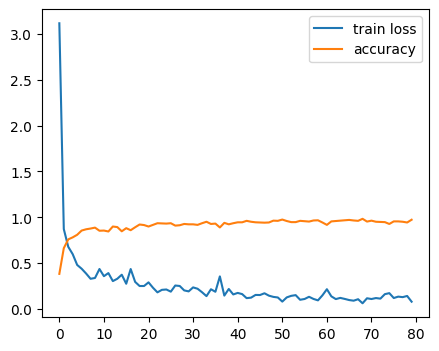

In [7]:
import tensorflow as tf
import trainer.data as data
import matplotlib.pyplot as plt

(train_data, train_labels) = data.create_data_with_labels("data/train/")
(eval_data, eval_labels) = data.create_data_with_labels("data/eval/")

img_shape = train_data.shape[1:]
input_layer = tf.keras.Input(shape=img_shape, name='input_image')

img_size = [160, 160]
ptm = tf.keras.applications.vgg16.VGG16(
    input_shape=img_size + [3],
    weights='imagenet',
    include_top=False)

ptm.trainable = False
i = ptm.input
# x = GlobalMaxPooling2D()(x)
x = tf.keras.layers.Flatten()(ptm.output)
#x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(5, activation='softmax')(x)

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=1000,  # You can tune this value
        decay_rate=0.96,   # 4% decrease every 1000 steps
        staircase=True)

# Compile the model with the learning rate schedule
model = tf.keras.models.Model(i, x)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,         # Randomly rotate images by 20 degrees
    width_shift_range=0.2,     # Randomly shift images horizontally
    height_shift_range=0.2,    # Randomly shift images vertically
    shear_range=0.2,           # Randomly shear images
    zoom_range=0.1,            # Randomly zoom in on images
    horizontal_flip=True,      # Randomly flip images horizontally
    fill_mode='nearest'        # Fill in new pixels after transformations
)

# Create augmented training data generator
train_gen = data_augmentation.flow(train_data, train_labels, batch_size=10)

r = model.fit(train_gen,
                 batch_size=10,
                 epochs=80)

fig, ax = plt.subplots(figsize = (5,4))
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['accuracy'], label='accuracy')
plt.legend()
fig.savefig("loss_accuracy_model_data_aug.svg")

model.evaluate(eval_data, eval_labels, verbose=1)

In [4]:
model.evaluate(eval_data, eval_labels, verbose=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - accuracy: 0.9032 - loss: 0.3424


[0.35088276863098145, 0.8960000276565552]